In [13]:
"Forgot to add the actual label of hatespeech during evaluation of LLMs xD, now adding the ground-truth for comparing results"

import json

def insert_label(file1, file2, output_file):
    idx_to_label = {}
    with open(file1, 'r', encoding='utf-8') as f1:
        for line in f1:
            record = json.loads(line)
            idx_to_label[record['idx']] = record['Hate Speech']  
    

    updated_records = []
    with open(file2, 'r', encoding='utf-8') as f2:
        for line in f2:
            record = json.loads(line)
            idx = record.get('id')  
            if idx in idx_to_label:
                record['label'] = idx_to_label[idx]  
            updated_records.append(record)
    

    with open(output_file, 'w', encoding='utf-8') as out_f:
        for record in updated_records:
            out_f.write(json.dumps(record, ensure_ascii=False) + '\n')

file1 = '/home/monoshi/Evaluating LLMs on Hate Speech Detection/data/sampled_dataset.jsonl'  
file2 = '/home/monoshi/Evaluating LLMs on Hate Speech Detection/results/llama/translated/results.jsonl'  
output_file = '/home/monoshi/Evaluating LLMs on Hate Speech Detection/results/llama/translated/added_label.jsonl' 


insert_label(file1, file2, output_file)


In [18]:
import os

def find_output_dirs(base_dir, target_dir="translated"):
    output_dirs = []
    for dirpath, dirnames, filenames in os.walk(base_dir):
        if target_dir in dirnames: 
            output_dirs.append(os.path.join(dirpath, target_dir))
    return output_dirs

base_directory = '/home/monoshi/Evaluating LLMs on Hate Speech Detection/results'


result_directories = find_output_dirs(base_directory)


for output_dir in result_directories:
    print(output_dir)


/home/monoshi/Evaluating LLMs on Hate Speech Detection/results/llama/translated
/home/monoshi/Evaluating LLMs on Hate Speech Detection/results/codellama7/translated
/home/monoshi/Evaluating LLMs on Hate Speech Detection/results/deepseek6.7/translated


In [32]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 4.7 MB/s eta 0:00:00a 0:00:01


In [44]:
import json
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

metrics_list = []


for output_directory in result_directories:
    jsonl_file_path = os.path.join(output_directory, 'results.jsonl')
    total_predictions = 0
    correct_predictions_speech = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    total_predictions_location = 0
    correct_predictions_location = 0

    try:
        if not os.path.isfile(jsonl_file_path):
            print(f"File not found: {jsonl_file_path}")
        else:
            with open(jsonl_file_path, 'r', encoding='utf-8') as file:
                for line_number, line in enumerate(file, start=1):
                    try:
                        item = json.loads(line)
                        item_id = item.get('id')
                        label = item.get('label')
                        geography = item.get('Hate Speech')
                        model = item.get('model')                          

                        response = item.get('response_data')

                        translated_comment = item.get('translated_comment')

                        item_output_without_input = response.get('output_without_input')
                        match_item_prediction = re.search(r'\[ANSWER\]\s*(.*?)\s*\[\/ANSWER\\?\]', item_output_without_input, re.DOTALL)
                        match_item_location = re.search(r'\[LOCATION\]\s*(.*?)\s*\[\/LOCATION\\?\]', item_output_without_input, re.DOTALL)

                        if match_item_prediction:
                            prediction_item_output_without_input = match_item_prediction.group(1).strip()
                        if match_item_location:
                            location_item_output_without_input = match_item_location.group(1).strip()


                        if label == "0":
                            label = "No"
                        else:
                            label = "Yes"

                        prediction_item_output_without_input = prediction_item_output_without_input.lower()

                        total_predictions += 1


                        if label == "Yes":
                            if prediction_item_output_without_input in ("yes", "y"):
                                correct_predictions_speech += 1
                                true_positives += 1
                                
                                if geography.lower() == location_item_output_without_input.lower():
                                    correct_predictions_location += 1    
                            else:
                                false_negatives += 1
                        elif label == "No":
                            if item_output_without_input in ("no", "n"):
                                correct_predictions_speech += 1
                                true_positives += 1
                            else:
                                false_positives += 1

                    except Exception as e:
                        print(f"Error processing line {line_number}: {e}")
                        print(f"Content: {line}")
                        print('-' * 40)

            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            
            print(f"Model: {model}")
            print(f"True Positives: {true_positives}")
            print(f"False Positives: {false_positives}")
            print(f"False Negatives: {false_negatives}")
            print(f"Total Predictions: {total_predictions}")
            print(f"Accuracy: {correct_predictions_speech / total_predictions * 100:.2f}%")
            print(f"Precision: {precision:.2f}")
            print(f"Recall: {recall:.2f}")
            print(f"F1 Score: {f1_score:.2f}")
            print(f"Correct Location: {correct_predictions_location}")
            
            
            metrics_list.append({
                "Model": model,
                "True Positives": true_positives,
                "False Positives": false_positives,
                "False Negatives": false_negatives,
                "Correct Predictions": correct_predictions_speech,
                "Correct Location": correct_predictions_location,
                "Total Predictions": total_predictions,
                "Accuracy": correct_predictions_speech / (total_predictions )* 100,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1_score,
            })


    except Exception as e:
        print(f"An error occurred: {e}")


Model: llama
True Positives: 94
False Positives: 302
False Negatives: 190
Total Predictions: 586
Accuracy: 16.04%
Precision: 0.24
Recall: 0.33
F1 Score: 0.28
Correct Location: 37
Model: codellama7
True Positives: 353
False Positives: 500
False Negatives: 147
Total Predictions: 1000
Accuracy: 35.30%
Precision: 0.41
Recall: 0.71
F1 Score: 0.52
Correct Location: 37
Model: deepseek6.7
True Positives: 265
False Positives: 500
False Negatives: 235
Total Predictions: 1000
Accuracy: 26.50%
Precision: 0.35
Recall: 0.53
F1 Score: 0.42
Correct Location: 63


In [45]:
print(metrics_list)

[{'Model': 'llama', 'True Positives': 94, 'False Positives': 302, 'False Negatives': 190, 'Correct Predictions': 94, 'Correct Location': 37, 'Total Predictions': 586, 'Accuracy': 16.040955631399317, 'Precision': 0.23737373737373738, 'Recall': 0.33098591549295775, 'F1 Score': 0.27647058823529413}, {'Model': 'codellama7', 'True Positives': 353, 'False Positives': 500, 'False Negatives': 147, 'Correct Predictions': 353, 'Correct Location': 37, 'Total Predictions': 1000, 'Accuracy': 35.3, 'Precision': 0.4138335287221571, 'Recall': 0.706, 'F1 Score': 0.5218033998521804}, {'Model': 'deepseek6.7', 'True Positives': 265, 'False Positives': 500, 'False Negatives': 235, 'Correct Predictions': 265, 'Correct Location': 63, 'Total Predictions': 1000, 'Accuracy': 26.5, 'Precision': 0.3464052287581699, 'Recall': 0.53, 'F1 Score': 0.4189723320158103}]


Index(['Model', 'True Positives', 'False Positives', 'False Negatives',
       'Correct Predictions', 'Correct Location', 'Total Predictions',
       'Accuracy', 'Precision', 'Recall', 'F1 Score'],
      dtype='object')


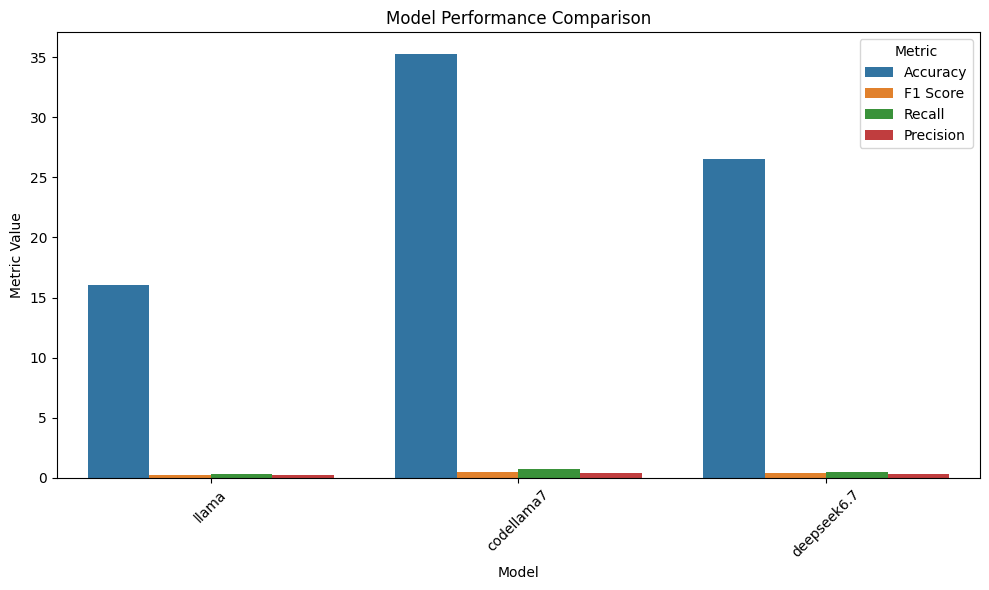

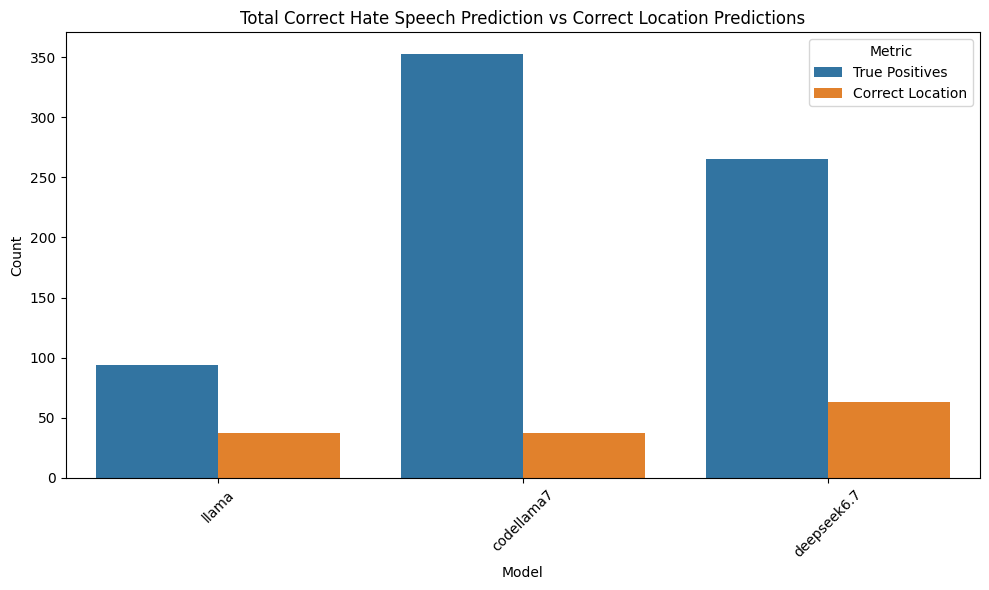

In [ ]:

metrics_df = pd.DataFrame(metrics_list)


metrics_df.to_csv('model_metrics.csv', index=False)

print(metrics_df.columns)



plt.figure(figsize=(10, 6))
metrics_melted = metrics_df.melt(id_vars="Model", value_vars=["Accuracy", "F1 Score", "Recall", "Precision"], 
                                 var_name="Metric", value_name="Value")
sns.barplot(data=metrics_melted, x="Model", y="Value", hue="Metric")
plt.title("Model Performance Comparison")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("performance_comparison.png")
plt.show()


plt.figure(figsize=(10, 6))
metrics_df_subset = metrics_df[["Model", "True Positives", "Correct Location"]]
metrics_df_subset = metrics_df_subset.melt(id_vars="Model", 
                                           var_name="Metric", value_name="Count")
sns.barplot(data=metrics_df_subset, x="Model", y="Count", hue="Metric")
plt.title("Total Correct Hate Speech Prediction vs Correct Location Predictions")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("tp_vs_location.png")
plt.show()